In [217]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#Pickling
from six.moves import cPickle as pickle
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

%matplotlib inline

no_alignment_file = [4764]
wrong_alignment = [3730]

In [26]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer

from gensim.models import word2vec
from gensim.models import KeyedVectors
from glove import Corpus, Glove

# Data Load Functions

In [27]:
def extract_patterns(data,extract=False):
    if(extract):
        patterns = {}
        for index, row in data.iterrows():
            patterns[row['index']] = set(get_pattern([row['text']])[0].values())
            print('Extracted pattern from '+ row['index'] + ' index:'+ str(index))
            print('Size: ', len(patterns[row['index']]), 'Patterns size', len(patterns))
        try:
            print('Saving Pickle')
            with open('pickles/patterns/pattern.pickle','wb') as f:
                save = {
                    'patterns' : patterns
                }
                pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
                print('Successfully saved in pattern.pickle')
                return patterns
        except Exception as e:
            print('Unable to save data to pickle', e)
            print('Patterns probably not saved.')
            return patterns
    else:
        try:
            with open('pickles/patterns/pattern.pickle','rb') as f:
                save = pickle.load(f)
                patterns = save['patterns']
                del save
                returning = {}
                for key in list(data['index']):
                    returning[key] = patterns[key]
                return returning
        except Exception as e:
            print('Error loading base datasets pickle: ', e)
            
def clean_text(text, remove_actions= True):
    punct_str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~«»“…‘”'
    if(remove_actions):
        text = re.sub(r" ?\[[^)]+\]", "", text)
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]


def remove_empty_patterns(data,patterns):
    empty_patterns = [k for k, v in patterns.items() if len(v) < 1]
    patterns = { k:v for k, v in patterns.items() if len(v) >= 1 }
    data = filter(lambda x: x[1]['index'] not in empty_patterns ,data.iterrows())
    data = pd.DataFrame.from_items(data).T
    return data,patterns

def remove_multiwildcard(patterns):
    for index, patt in patterns.items():
        flt_patt = {p for p in patt if p.split(' ').count('.+') == 1}
        patterns[index] = flt_patt
    return patterns

def load_data(word_count,emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences_votebased.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 4]
    #Remove rows that don't have Alignment file
    try:
        data = data.drop(no_alignment_file)
    except Exception as e:
        print('Error at: ',e)
    # Remove rows that have wrong Alignment file
    try:
        data = data.drop(wrong_alignment)
    except Exception as e:
        print('Error at: ',e)
#     Clean Transcripts
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
    patterns = extract_patterns(data)
    data,patterns = remove_empty_patterns(data,patterns)
    patterns = remove_multiwildcard(patterns)
    return data,patterns

def load_acoustic_fullmatrices(extraction_type = 'full',extract_fd = False):
    if(extraction_type in ['full','wc','cw']):
        try:
            if(extract_fd):
                fullmfcc_matrix_fd = None
                fullrmse_matrix_fd = pd.read_pickle('pickles/patterns/'+extraction_type+'_rmse_matrix_fd.pickle')
                print('Successfully loaded '+extraction_type+' RMSE Matrix FULLDATA')
                fullzcr_matrix_fd = pd.read_pickle('pickles/patterns/'+extraction_type+'_zcr_matrix_fd.pickle')
                print('Successfully loaded '+extraction_type+' ZCR Matrix FULLDATA')   
                with open('pickles/patterns/'+extraction_type+'_mfcc20_matrix_fd.pickle','rb') as f:
                    save = pickle.load(f)
                    fullmfcc_matrix_fd = save['multimatrix']
                    del save
                print('Successfully loaded '+extraction_type+' MFCC Matrices FULLDATA')
                fullmfcc_matrix_fd.append(fullrmse_matrix_fd)
                fullmfcc_matrix_fd.append(fullzcr_matrix_fd)
                return fullmfcc_matrix_fd
            else:
                fullmfcc_matrix = None
                fullrmse_matrix = pd.read_pickle('pickles/patterns/'+extraction_type+'_rmse_matrix.pickle')
                print('Successfully loaded '+extraction_type+' RMSE Matrix')   
                fullzcr_matrix = pd.read_pickle('pickles/patterns/'+extraction_type+'_zcr_matrix.pickle')
                print('Successfully loaded '+extraction_type+' ZCR Matrix')
                with open('pickles/patterns/'+extraction_type+'_mfcc20_matrix.pickle','rb') as f:
                    save = pickle.load(f)
                    fullmfcc_matrix = save['multimatrix']
                    del save
                print('Successfully loaded '+extraction_type+' MFCC Matrices') 
                fullmfcc_matrix.append(fullrmse_matrix)
                fullmfcc_matrix.append(fullzcr_matrix)
                return fullmfcc_matrix
        except Exception as e:
            print('Error loading matrix: ', e)
    else:
        print('Error')
        return None,None


In [33]:
# DATASET
seed = 7
np.random.seed(seed)
emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}

data, patterns = load_data(3,emotional_mapping)
# x_train, x_test, y_train, y_test = train_test_split(data, data.emotion_code, test_size=TEST_SIZE)
try:
    with open('pickles/matrix_basedata.pickle','rb') as f:
        save = pickle.load(f)
        X_train = save['X_train']
        X_test = save['X_test']
        y_train = save['y_train']
        y_test = save['y_test']
        del save
except Exception as e:
    print('Error loading base datasets pickle: ', e)

    
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values


data.groupby('emotion').count()['index']

Error at:  labels [4764] not contained in axis


emotion
ang    1141
hap     680
neu    1440
sad     947
Name: index, dtype: int64

In [193]:
# full_matrices = load_acoustic_fullmatrices(extraction_type='full')
# wc_matrices = load_acoustic_fullmatrices(extraction_type='wc')
# cw_matrices = load_acoustic_fullmatrices(extraction_type='cw')
##################### FULLDATA ACOUSTIC MATRICES ###################################
full_matrices = load_acoustic_fullmatrices(extraction_type='full',extract_fd = True)
wc_matrices = load_acoustic_fullmatrices(extraction_type='wc',extract_fd = True)
cw_matrices = load_acoustic_fullmatrices(extraction_type='cw',extract_fd = True)
########################################################################################
RMSE_INDEX = 20
ZCR_INDEX = 21
###########################################################################################

em_df = pd.read_pickle('pickles/patterns/pfief_matrix.pickle')

patterns_list = np.array(list(em_df.index))
print(len(em_df),len(full_matrices),len(wc_matrices),len(cw_matrices))

Successfully loaded full RMSE Matrix FULLDATA
Successfully loaded full ZCR Matrix FULLDATA
Successfully loaded full MFCC Matrices FULLDATA
Successfully loaded wc RMSE Matrix FULLDATA
Successfully loaded wc ZCR Matrix FULLDATA
Successfully loaded wc MFCC Matrices FULLDATA
Successfully loaded cw RMSE Matrix FULLDATA
Successfully loaded cw ZCR Matrix FULLDATA
Successfully loaded cw MFCC Matrices FULLDATA
5853 22 22 22


In [194]:
def get_frequency_vectors(data,patterns_list):
    patterns = extract_patterns(data)
    transcript_order = list(data['index'])
    frequency_vectors = []
    for index in patterns:
        frequency_vectors.append(np.isin(patterns_list,np.array(list(patterns[index]))))
    vectors = pd.DataFrame(frequency_vectors,columns=patterns_list,index=patterns.keys())
    vectors = vectors.loc[transcript_order]
    vectors = vectors * 1
    return vectors

vectors = get_frequency_vectors(X_train,patterns_list)
test_vectors = get_frequency_vectors(X_test,patterns_list)

In [189]:
vectors.head()

,.+ a,.+ a big,.+ a bit,.+ a day,.+ a dog,.+ a few,.+ a good,.+ a guy,.+ a little,.+ a lot,...,your .+ with,your .+ you,your .+ your,your a .+,your life .+,your name .+,your own .+,yours .+,yourself .+,yourself a .+
Ses04F_script03_2_M001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ses05M_script02_1_F016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ses04F_script01_2_F013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ses02F_script03_1_F010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ses03M_impro08a_F014,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
test_vectors.head()

,.+ a,.+ a big,.+ a bit,.+ a day,.+ a dog,.+ a few,.+ a good,.+ a guy,.+ a little,.+ a lot,...,your .+ with,your .+ you,your .+ your,your a .+,your life .+,your name .+,your own .+,yours .+,yourself .+,yourself a .+
Ses05F_impro02_F024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ses01M_script01_1_F014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ses03F_impro04_M019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ses02M_impro05_M013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ses03F_impro08_M002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
vectors.loc['Ses02F_impro08_F010']['.+ by the']

1

# Parameter

In [216]:
# EMBEDDING
EMBEDDING_DIM  = 4
MAX_SEQ_LENGTH = 170

# MODEL
FILTER_SIZES   = [1,1,1]
FEATURE_MAPS   = [150,150,150]
DROPOUT_RATE   = 0.2

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 50
RUNS           = 5
VAL_SIZE       = 0.2
LEARNING_RATE  = 0.01

In [97]:
result = [np.sum(x[1]) for x in vectors.iterrows()]

print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    data.append(pad)
    

test_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    test_data.append(pad)

data2 = []
# for key, row in vectors.iterrows():
#     neg_patt = [i for i,v in row.iteritems() if v == 0]
#     row_matrix = em_df.copy()
#     row_matrix.loc[neg_patt] = 0
#     data2.append(row_matrix.as_matrix())
    
test_data2 = []
# for key, row in test_vectors.iterrows():
#     neg_patt = [i for i,v in row.iteritems() if v == 0]
#     row_matrix = em_df.copy()
#     row_matrix.loc[neg_patt] = 0
#     test_data2.append(row_matrix.as_matrix())
    

Text informations:
max length: 165 / min length: 1 / mean length: 25 / limit length: 170


In [98]:
np.array(data2).shape, y_train.shape, np.array(test_data2).shape, y_test.shape

((0,), (3366, 4), (0,), (842, 4))

In [99]:
np.array(data).shape, y_train.shape, np.array(test_data).shape, y_test.shape

((3366, 170, 4), (3366, 4), (842, 170, 4), (842, 4))

# Conv1D Baseline

In [100]:
import ap_cnn_model
import time  

histories = []
for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    start_time = time.time()
    emb_layer = None
    
    model = ap_cnn_model.build_cnn(
        embedding_dim= EMBEDDING_DIM,
        filter_sizes = FILTER_SIZES,
        feature_maps = FEATURE_MAPS,
        max_seq_length = MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
        metrics=['accuracy']
    )
    
    history = model.fit(
        [data], y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=([test_data], y_test),
        callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=0, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print('Iteration', i+1)
    print("--- %s seconds on ---" % (time.time() - start_time))

Running iteration 1/2
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [3, 5]
Feature maps: [50, 50]
Max sequence: 170
#############################################
Hello
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 8s 2ms/step - loss: 1.0249 - acc: 0.7365 - val_loss: 1.0058 - val_acc: 0.7461
Epoch 2/50
3366/3366 [==============================] - 1s 421us/step - loss: 1.0237 - acc: 0.7351 - val_loss: 1.0056 - val_acc: 0.7461
Epoch 3/50
3366/3366 [==============================] - 1s 433us/step - loss: 1.0241 - acc: 0.7363 - val_loss: 1.0055 - val_acc: 0.7461
Epoch 4/50
3366/3366 [==============================] - 1s 442us/step - loss: 1.0237 - acc: 0.7347 - val_loss: 1.0053 - val_acc: 0.7458
Epoch 5/50
3366/3366 [==============================] - 1s 429us/step - loss: 1.0257 - acc: 0.7343 - val_loss: 1.0052 - val_acc: 0.7455
Epoch 6/50
3366/33

3366/3366 [==============================] - 1s 431us/step - loss: 1.0189 - acc: 0.7348 - val_loss: 1.0020 - val_acc: 0.7491
Epoch 7/50
3366/3366 [==============================] - 1s 414us/step - loss: 1.0163 - acc: 0.7386 - val_loss: 1.0019 - val_acc: 0.7491
Epoch 8/50
3366/3366 [==============================] - 1s 423us/step - loss: 1.0176 - acc: 0.7361 - val_loss: 1.0018 - val_acc: 0.7491
Epoch 9/50
3366/3366 [==============================] - 1s 429us/step - loss: 1.0138 - acc: 0.7369 - val_loss: 1.0017 - val_acc: 0.7491
Epoch 10/50
3366/3366 [==============================] - 2s 461us/step - loss: 1.0171 - acc: 0.7383 - val_loss: 1.0016 - val_acc: 0.7491
Epoch 11/50
3366/3366 [==============================] - 1s 415us/step - loss: 1.0181 - acc: 0.7369 - val_loss: 1.0015 - val_acc: 0.7491
Epoch 12/50
3366/3366 [==============================] - 1s 437us/step - loss: 1.0151 - acc: 0.7392 - val_loss: 1.0014 - val_acc: 0.7491
Epoch 13/50
3366/3366 [==============================] -

In [101]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

def get_scores_from_multiple(history_folder):
    V_folder = os.listdir(history_folder)
    values = []
    for pkl in V_folder:
        history = pickle.load(open(history_folder+pkl, 'rb'))
        values.append([pkl,get_avg(history,'acc'),get_avg(history,'val_acc'),get_avg(history,'loss'),get_avg(history,'val_loss')])
    # histories = pickle.load(open('history/unbalanced_glovetext8_2500.pkl', 'rb'))
    scores = pd.DataFrame(data=values,columns=['Model','Train Acc','Valid Acc','Train Loss','Valid Loss'])
    return scores

def  plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

Training: 	0.6768 loss / 0.7979 acc
Validation: 	0.7111 loss / 0.7806 acc


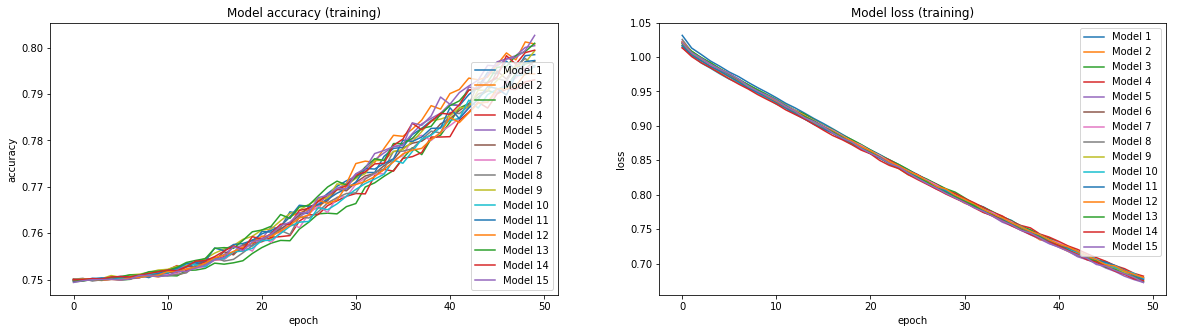

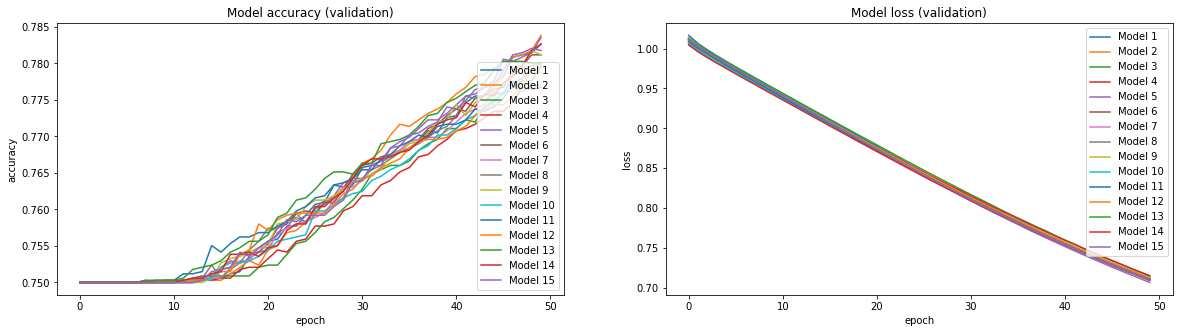

In [209]:
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

# Multichannel CNN

In [280]:
acoustic_matrix = full_matrices[RMSE_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

NUM_CHANNELS = 2

#######################################
full_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    full_data.append([pad, acu_pad])
    
test_full_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_full_data.append([pad, acu_pad])



In [281]:
acoustic_matrix = cw_matrices[RMSE_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

cw_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    cw_data.append([pad, acu_pad])
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_cw_data.append([pad, acu_pad])

In [ ]:
acoustic_matrix = wc_matrices[RMSE_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

wc_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    wc_data.append([pad, acu_pad])
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_wc_data.append([pad, acu_pad])

In [242]:
np.array(full_data).shape, y_train.shape, np.array(test_full_data).shape, y_test.shape

((3366, 2, 170, 4), (3366, 4), (842, 2, 170, 4), (842, 4))

In [244]:
np.array(cw_data).shape, np.array(wc_data).shape, np.array(test_cw_data).shape, np.array(test_wc_data).shape

((3366, 2, 170, 4), (3366, 2, 170, 4), (842, 2, 170, 4), (842, 2, 170, 4))

In [248]:
import keras_metrics
import multiap_cnn_model
import time  

In [249]:

# histories = []
# for i in range(1):
#     print('Running iteration %i/%i' % (i+1, RUNS))
#     start_time = time.time()
#     emb_layer = None
    
#     model = multiap_cnn_model.build_cnn(
#         embedding_dim= EMBEDDING_DIM,
#         filter_sizes = FILTER_SIZES,
#         feature_maps = FEATURE_MAPS,
#         num_channels= NUM_CHANNELS,
#         max_seq_length = MAX_SEQ_LENGTH,
#         dropout_rate=DROPOUT_RATE
#     )
    
#     model.compile(
#         loss='binary_crossentropy',
#         optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#         metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
#     )
    
#     history = model.fit(
#         [data], y_train,
#         epochs=10,#NB_EPOCHS,
#         batch_size=BATCH_SIZE,
#         verbose=1,
#         validation_data=([test_data], y_test),
#         callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
#                                    verbose=0, save_best_only=True, mode='min'),
#                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#                   ]
#     )
#     histories.append(history.history)
#     print('Iteration', i+1)
#     print("--- %s seconds on ---" % (time.time() - start_time))

Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/10
3366/3366 [==============================] - 39s 12ms/step - loss: 1.2621 - acc: 0.7493 - precision: 0.2828 - recall: 0.0053 - val_loss: 1.2470 - val_acc: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
3366/3366 [==============================] - 11s 3ms/step - loss: 1.2396 - acc: 0.7512 - precision: 0.5742 - recall: 0.0092 - val_loss: 1.2348 - val_acc: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
3366/3366 [==============================] - 11s 3ms/step - loss: 1.2245 - acc: 0.7536 - precision: 0.8511 - recall: 0.0166 - val_loss: 1.2243 - val_acc: 0.7503 - val_precision: 0.2375 - val_recall: 0.0012
Epoch 4/10
3366/3366 [==

In [ ]:
import multiap_cnn_model
# # BALANCED DATA
printing = {}
FILTER_SIZES_AR   = [[1,1,1],[5,5,5],[1,3,5],[1,2,2],[1,2,3],[2,3,5]]
filter_sizes_names = ['1_1_1','5_5_5','1_3_5','1_2_2','1_2_3','2_3_5']
FEATURE_MAPS_AR   = [[150,150,150],[100,100,100]]
feature_maps_names = ['150','100']
DROPOUT_RATE = 0.2
LEARNING_RATE  = 0.01
RUNS = 5
DATA_AR = [full_data, wc_data,cw_data]
TEST_DATA_AR = [test_full_data,test_wc_data,test_cw_data]
data_names = ['full','wc','cw']
MAX_SEQ_LENGTH = 170
for Findex,filterS in enumerate(FILTER_SIZES_AR):
    for Mindex, featureM in enumerate(FEATURE_MAPS_AR):
        for Dindex, dataV in enumerate(DATA_AR):
            FILTER_SIZES = filterS
            FEATURE_MAPS = featureM
            histories = []
            for i in range(RUNS):
                print('Running iteration %i/%i' % (i+1, RUNS))
                start_time = time.time()
                emb_layer = None

                model = multiap_cnn_model.build_cnn(
                    embedding_dim= EMBEDDING_DIM,
                    filter_sizes = FILTER_SIZES,
                    feature_maps = FEATURE_MAPS,
                    max_seq_length = MAX_SEQ_LENGTH,
                    dropout_rate=DROPOUT_RATE,
                    num_channels=NUM_CHANNELS
                )

                model.compile(
                    loss='binary_crossentropy',
                    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
                    metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
                )

                history = model.fit(
                    [dataV], y_train,
                    epochs=NB_EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2,
                    validation_data=([TEST_DATA_AR[Dindex]], y_test),
                    callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                               verbose=2, save_best_only=True, mode='min'),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                              ]
                )
                histories.append(history.history)
                print('Iteration', i+1)
                print("--- %s seconds on ---" % (time.time() - start_time))

            with open('history/rmse/_FS'+str(filter_sizes_names[Findex])+'_FM_'+str(feature_maps_names[Mindex])+'_data_'+str(data_names[Dindex])+'.pkl', 'wb') as f:
                pickle.dump(histories, f)



Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
 - 38s - loss: 1.2376 - acc: 0.7496 - precision: 0.2803 - recall: 0.0051 - val_loss: 1.2239 - val_acc: 0.7503 - val_precision: 0.2375 - val_recall: 0.0012

Epoch 00001: val_loss improved from inf to 1.22391, saving model to model-1.h5
Epoch 2/50
 - 11s - loss: 1.2145 - acc: 0.7521 - precision: 0.7091 - recall: 0.0134 - val_loss: 1.2118 - val_acc: 0.7503 - val_precision: 0.2375 - val_recall: 0.0012

Epoch 00002: val_loss improved from 1.22391 to 1.21180, saving model to model-1.h5
Epoch 3/50
 - 11s - loss: 1.1987 - acc: 0.7542 - precision: 0.8290 - recall: 0.0205 - val_loss: 1.2016 - val_acc: 0.7512 - val_precision: 0.9501 - val_recall: 0.0048

Epoch 00003: val_loss improve

In [ ]:
acoustic_matrix = full_matrices[ZCR_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

NUM_CHANNELS = 2

#######################################
full_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    full_data.append([pad, acu_pad])
    
test_full_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_full_data.append([pad, acu_pad])

acoustic_matrix = cw_matrices[ZCR_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

cw_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    cw_data.append([pad, acu_pad])
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_cw_data.append([pad, acu_pad])

acoustic_matrix = wc_matrices[ZCR_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

wc_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    wc_data.append([pad, acu_pad])
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_wc_data.append([pad, acu_pad])

In [ ]:
import multiap_cnn_model
# # BALANCED DATA
printing = {}
FILTER_SIZES_AR   = [[1,1,1],[5,5,5],[1,3,5],[1,2,2],[1,2,3],[2,3,5]]
filter_sizes_names = ['1_1_1','5_5_5','1_3_5','1_2_2','1_2_3','2_3_5']
FEATURE_MAPS_AR   = [[150,150,150],[100,100,100]]
feature_maps_names = ['150','100']
DROPOUT_RATE = 0.2
LEARNING_RATE  = 0.01
RUNS = 5
DATA_AR = [full_data, wc_data,cw_data]
TEST_DATA_AR = [test_full_data,test_wc_data,test_cw_data]
data_names = ['full','wc','cw']
MAX_SEQ_LENGTH = 170
for Findex,filterS in enumerate(FILTER_SIZES_AR):
    for Mindex, featureM in enumerate(FEATURE_MAPS_AR):
        for Dindex, dataV in enumerate(DATA_AR):
            FILTER_SIZES = filterS
            FEATURE_MAPS = featureM
            histories = []
            for i in range(RUNS):
                print('Running iteration %i/%i' % (i+1, RUNS))
                start_time = time.time()
                emb_layer = None

                model = multiap_cnn_model.build_cnn(
                    embedding_dim= EMBEDDING_DIM,
                    filter_sizes = FILTER_SIZES,
                    feature_maps = FEATURE_MAPS,
                    max_seq_length = MAX_SEQ_LENGTH,
                    dropout_rate=DROPOUT_RATE,
                    num_channels=NUM_CHANNELS
                )

                model.compile(
                    loss='binary_crossentropy',
                    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
                    metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
                )

                history = model.fit(
                    [dataV], y_train,
                    epochs=NB_EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2,
                    validation_data=([TEST_DATA_AR[Dindex]], y_test),
                    callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                               verbose=2, save_best_only=True, mode='min'),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                              ]
                )
                histories.append(history.history)
                print('Iteration', i+1)
                print("--- %s seconds on ---" % (time.time() - start_time))

            with open('history/zcr/_FS'+str(filter_sizes_names[Findex])+'_FM_'+str(feature_maps_names[Mindex])+'_data_'+str(data_names[Dindex])+'.pkl', 'wb') as f:
                pickle.dump(histories, f)



In [ ]:
acoustic_matrix = full_matrices[0]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

NUM_CHANNELS = 2

#######################################
full_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    full_data.append([pad, acu_pad])
    
test_full_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_full_data.append([pad, acu_pad])

acoustic_matrix = cw_matrices[0]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

cw_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    cw_data.append([pad, acu_pad])
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_cw_data.append([pad, acu_pad])

acoustic_matrix = wc_matrices[0]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

wc_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    wc_data.append([pad, acu_pad])
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_wc_data.append([pad, acu_pad])

In [ ]:
import multiap_cnn_model
# # BALANCED DATA
printing = {}
FILTER_SIZES_AR   = [[1,1,1],[5,5,5],[1,3,5],[1,2,2],[1,2,3],[2,3,5]]
filter_sizes_names = ['1_1_1','5_5_5','1_3_5','1_2_2','1_2_3','2_3_5']
FEATURE_MAPS_AR   = [[150,150,150],[100,100,100]]
feature_maps_names = ['150','100']
DROPOUT_RATE = 0.2
LEARNING_RATE  = 0.01
RUNS = 5
DATA_AR = [full_data, wc_data,cw_data]
TEST_DATA_AR = [test_full_data,test_wc_data,test_cw_data]
data_names = ['full','wc','cw']
MAX_SEQ_LENGTH = 170
for Findex,filterS in enumerate(FILTER_SIZES_AR):
    for Mindex, featureM in enumerate(FEATURE_MAPS_AR):
        for Dindex, dataV in enumerate(DATA_AR):
            FILTER_SIZES = filterS
            FEATURE_MAPS = featureM
            histories = []
            for i in range(RUNS):
                print('Running iteration %i/%i' % (i+1, RUNS))
                start_time = time.time()
                emb_layer = None

                model = multiap_cnn_model.build_cnn(
                    embedding_dim= EMBEDDING_DIM,
                    filter_sizes = FILTER_SIZES,
                    feature_maps = FEATURE_MAPS,
                    max_seq_length = MAX_SEQ_LENGTH,
                    dropout_rate=DROPOUT_RATE,
                    num_channels=NUM_CHANNELS
                )

                model.compile(
                    loss='binary_crossentropy',
                    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
                    metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
                )

                history = model.fit(
                    [dataV], y_train,
                    epochs=NB_EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2,
                    validation_data=([TEST_DATA_AR[Dindex]], y_test),
                    callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                               verbose=2, save_best_only=True, mode='min'),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                              ]
                )
                histories.append(history.history)
                print('Iteration', i+1)
                print("--- %s seconds on ---" % (time.time() - start_time))

            with open('history/mfcc1/_FS'+str(filter_sizes_names[Findex])+'_FM_'+str(feature_maps_names[Mindex])+'_data_'+str(data_names[Dindex])+'.pkl', 'wb') as f:
                pickle.dump(histories, f)

